In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import clear_output


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        clear_output(wait=True)
    print('done')
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

done


In [31]:
import os
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torch.nn.functional as F
from torchmetrics.functional import peak_signal_noise_ratio as PSNR
from sklearn.model_selection import train_test_split
import cv2
import joblib
from scipy.stats import gaussian_kde
from xgboost import XGBRegressor
from tqdm import tqdm
import pickle

In [10]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [8]:
def load_images(dir, name):
    return torch.stack([
        torch.from_numpy(np.array(Image.open(os.path.join(dir, f))))
        for f in tqdm(sorted(os.listdir(dir)), desc=f'Loading {name} images') if f.endswith('.png')
    ]).permute(0, 3, 1, 2) / 255

high_dir = '/kaggle/input/lol-dataset/lol_dataset/our485/high'
low_dir = '/kaggle/input/lol-dataset/lol_dataset/our485/low'

hi = load_images(high_dir, 'high_dir')
lo = load_images(low_dir, 'low_dir')

Loading low_dir images: 100%|██████████| 485/485 [00:03<00:00, 129.27it/s]


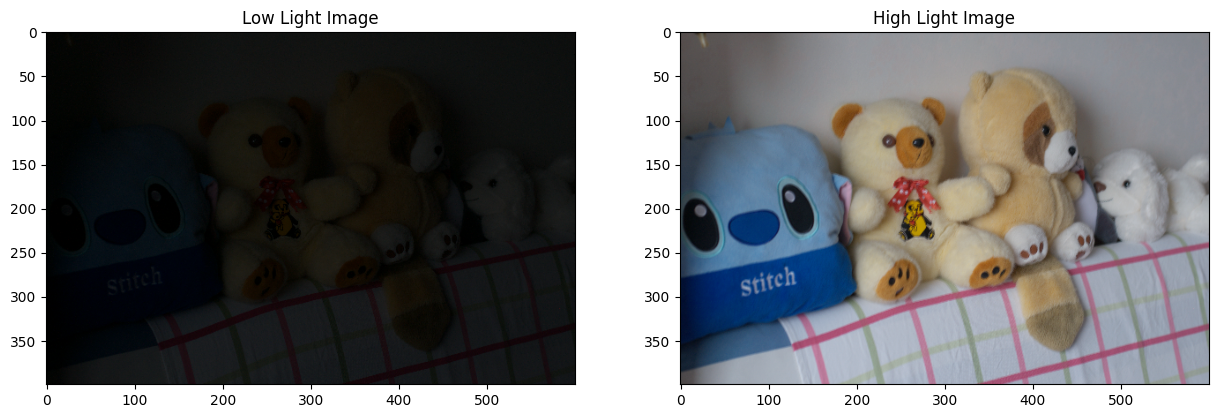

In [9]:
plt.figure(figsize=(15, 20))

plt.subplot(1, 2, 1)
plt.imshow(lo[0].permute(1, 2, 0).numpy())
plt.title('Low Light Image')

plt.subplot(1, 2, 2)
plt.imshow(hi[0].permute(1, 2, 0).numpy())
plt.title('High Light Image')

plt.show()

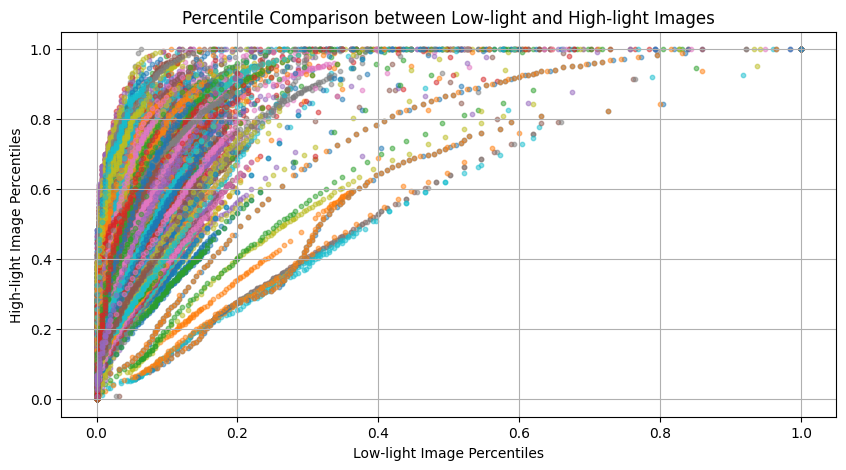

Number of pairs with correlation < 0.3: 0
Number of pairs with correlation between 0.3 and 0.6: 40
Number of pairs with correlation > 0.6: 445


In [11]:
def ptile(pixels, quantiles):
    return np.percentile(pixels, quantiles)

def corre(lp, hp, quantiles=np.linspace(0, 100, 100)):
    plt.figure(figsize=(10, 5))
    
    correlations = [
        np.corrcoef(ptile(l.flatten(), quantiles), ptile(h.flatten(), quantiles))[0, 1]
        for l, h in zip(lp, hp)
    ]
    
    for i, (l, h) in enumerate(zip(lp, hp)):
        plt.scatter(ptile(l.flatten(), quantiles), ptile(h.flatten(), quantiles), label=f'Pair {i+1}', alpha=0.5, s=10)
    
    plt.title('Percentile Comparison between Low-light and High-light Images')
    plt.xlabel('Low-light Image Percentiles')
    plt.ylabel('High-light Image Percentiles')
    plt.grid(True)
    plt.show()
    
    return correlations


lp, hp = lo[:485], hi[:485]
correlations = corre(lp, hp)

a= sum(corr < 0.3 for corr in correlations)
b = sum(0.3 <= corr <= 0.6 for corr in correlations)
c = sum(corr > 0.6 for corr in correlations)

print(f'Number of pairs with correlation < 0.3: {a}')
print(f'Number of pairs with correlation between 0.3 and 0.6: {b}')
print(f'Number of pairs with correlation > 0.6: {c}')


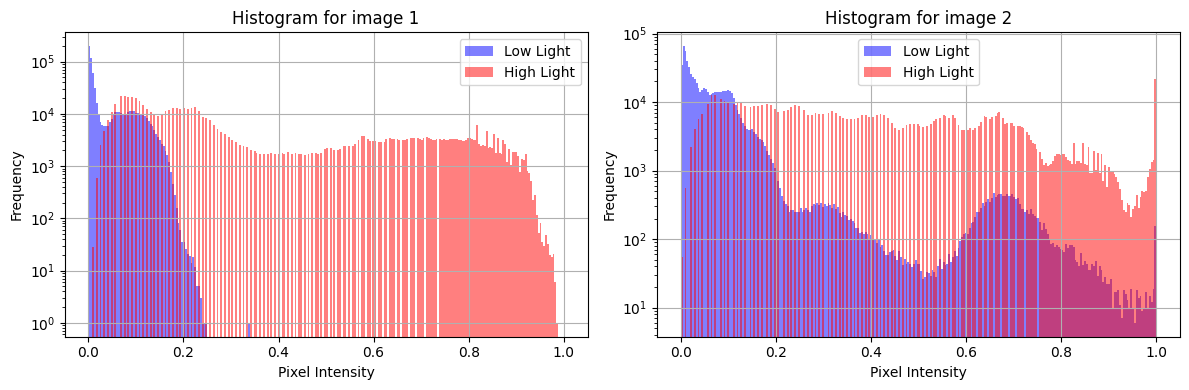

In [7]:
def plot_histogram(ax, image_low, image_high, title, color_low, color_high):
    ax.hist(image_low.flatten(), bins=256, range=(0, 1), color=color_low, alpha=0.5, label='Low Light')
    ax.hist(image_high.flatten(), bins=256, range=(0, 1), color=color_high, alpha=0.5, label='High Light')
    ax.set_title(title)
    ax.set_xlabel('Pixel Intensity')
    ax.set_ylabel('Frequency')
    ax.grid(True)
    ax.set_yscale('log')  
    ax.legend()

fig, axs = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

for i, ax in enumerate(axs):
    plot_histogram(ax, lo[i+1], hi[i+1], title=f'Histogram for image {i+1}', color_low='blue', color_high='red')

plt.tight_layout()
plt.show()


In [12]:
def dfq(q, b=0.75):
    return gaussian_kde(q, b * np.std(q))(np.linspace(0, 1, 255))

def adjh(img, th):
    ih = np.histogram(img, bins=256, range=(0, 1))[0]
    ih, th = ih / np.sum(ih), th / np.sum(th)
    tf = np.interp(np.cumsum(ih), np.cumsum(th), np.linspace(0, 1, 255))
    return np.interp(img, np.linspace(0, 1, 256), tf)


In [17]:
def avg(lst):
    return sum(lst) / len(lst) if lst else None

def find_best_n(hi, lo, j):
    lx = lo.reshape(-1, 400, 600)
    ix = np.array([np.histogram(img, bins=256, range=(0, 1))[0] for img in lx])
    ql = []
    for h in hi.reshape(lo.shape[0] * 3, lo.shape[2], lo.shape[3]):
        ql.append(np.percentile(h, np.linspace(0, 100, j)))
    
    qa = np.array(ql)
    mdl = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, tree_method='hist')
    print('Model selection started')
    mdl.fit(ix, qa)
    print('Model fitted')
    out = mdl.predict(ix)
    print('Output produced')
    
    ni = []
    for i in range(len(lo)):
        ims = []
        for k in range(3):
            hist = dfq(out[3*i + k])
            ims.append(adjh(lo[i][k], hist))
        ni.append(ims)
    
    ni = torch.from_numpy(np.array(ni)).float()
    n_inp = [img.reshape(3, 400, 600) for img in ni]
    print('New inputs ready')
    np50, hp50 = n_inp[:50], hi[:50]
    ss = corre(np50, hp50, quantiles=np.linspace(0, 100, 100))

    av = avg(ss)
    return av, j

Model selection started
Model fitted
Output produced
New inputs ready


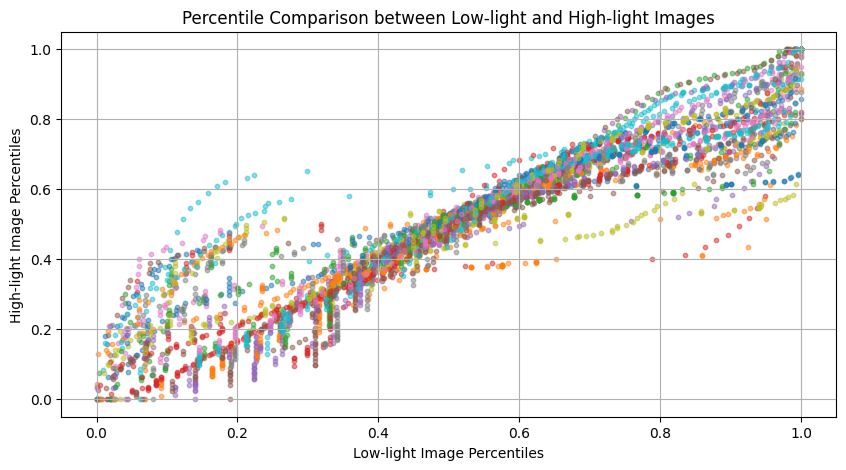

best: 5
Model selection started
Model fitted
Output produced
New inputs ready


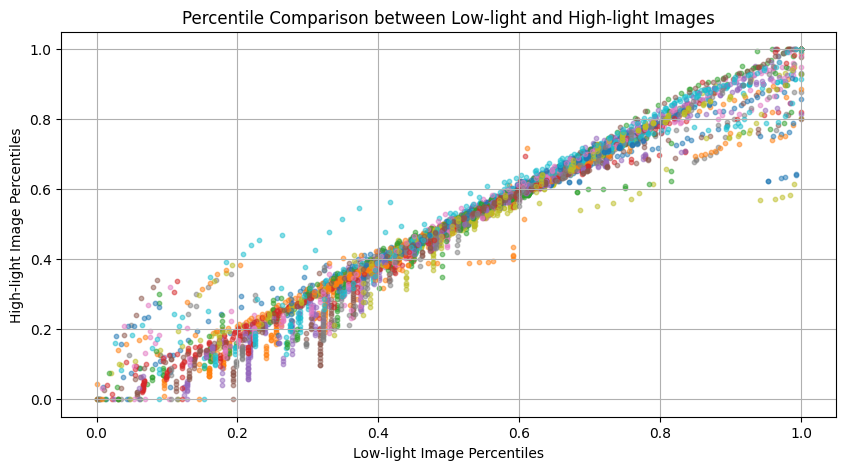

best: 15
Model selection started
Model fitted
Output produced
New inputs ready


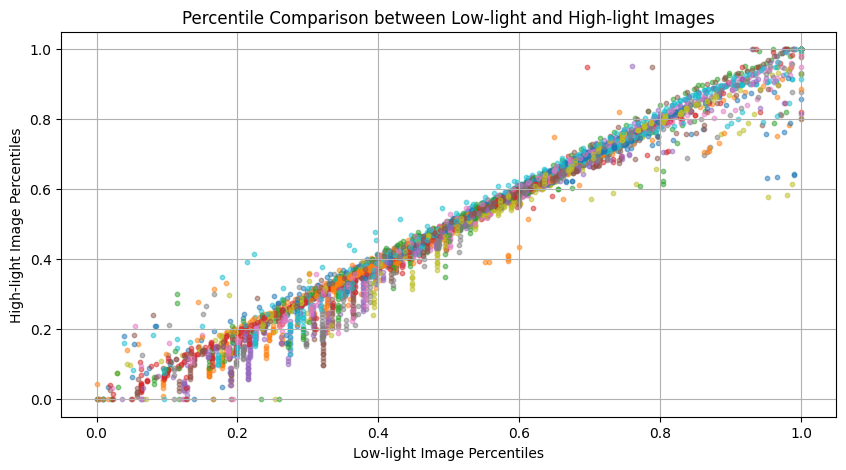

best: 25
Model selection started
Model fitted
Output produced
New inputs ready


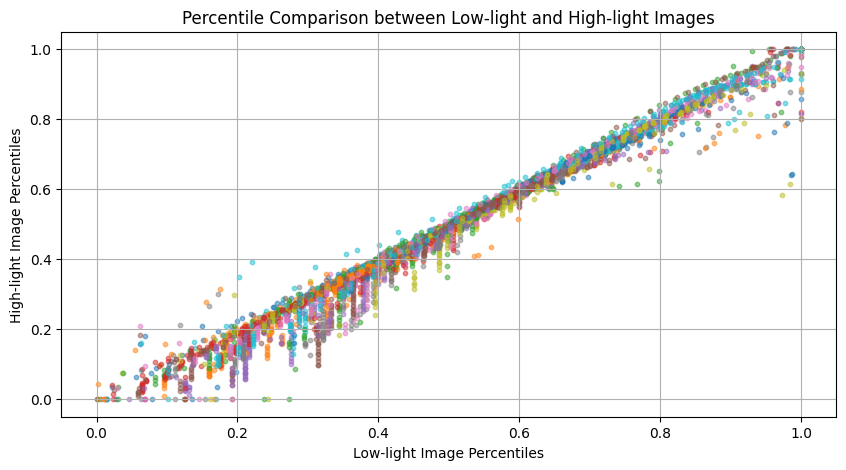

best: 35
Model selection started
Model fitted
Output produced
New inputs ready


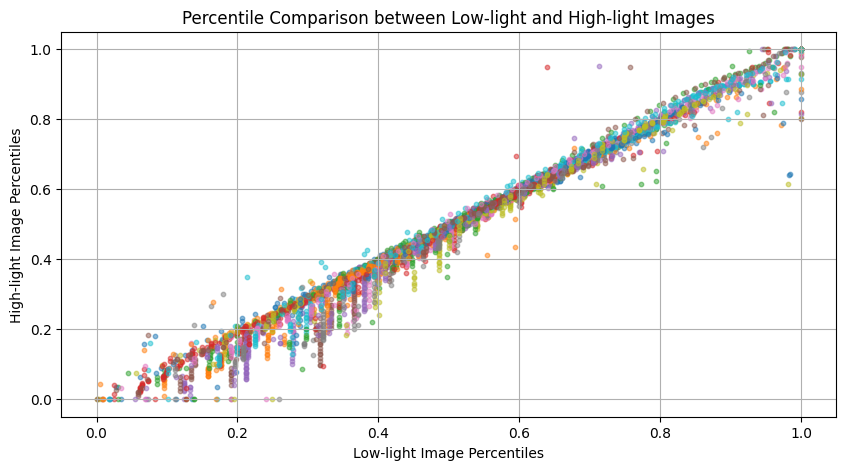

best: 45
Model selection started
Model fitted
Output produced
New inputs ready


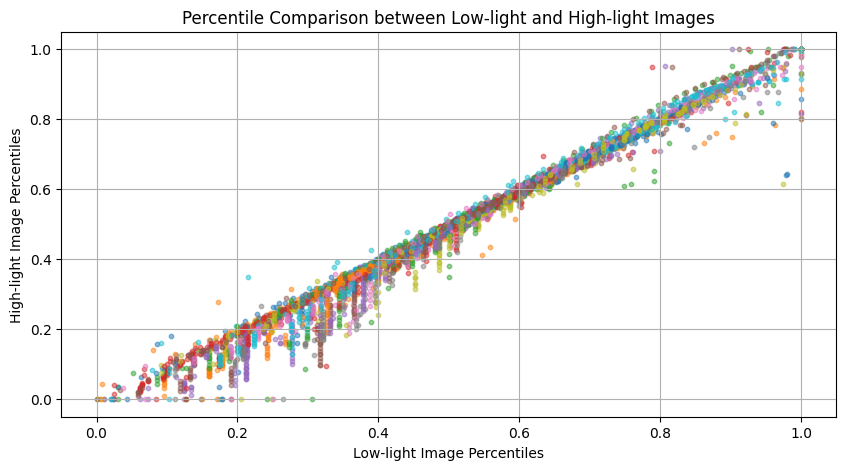

stawwp
best: 55


In [18]:
curr = 0
th = 0.01
patience = 0
for i in range(5, 95, 10):
    av, qtl = find_best_n(hi,lo,i)
    if patience <3:
        if av - curr > th:
            print('best:',qtl)
            curr = av
            patience = 0
        else:
            patience+=1
            print('best:',qtl)
    else:
        print('stawwp')
        print('best:',qtl)
        break

train for n = 35

In [14]:
    input_x = np.array([np.histogram(img, bins=256, range=(0,1))[0] for img in lo.reshape(-1, 400, 600)])
    quantiles_list = []
    shape = (lo.shape[0] * 3, lo.shape[2], lo.shape[3])   
    for high_image in hi.reshape(shape):
        quantiles = np.percentile(high_image, np.linspace(0, 100, 25))
        quantiles_list.append(quantiles)

    quantiles_array = np.array(quantiles_list)
    model_xgb = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, tree_method='hist')
    print('we choose the model')
    model_xgb.fit(input_x, quantiles_array)
    print('model fitted, yay!')
    out = model_xgb.predict(np.array([np.histogram(img, bins=256, range=(0,1))[0] for img in lo.reshape(-1, 400, 600)]))
    print('output produced!!')
    new_input = []
    for i in range(len(lo)):
        im=[]
        hist = dfq(out[3*i])
        im.append(adjh(lo[i][0], hist))
        hist = dfq(out[3*i+1])
        im.append(adjh(lo[i][1], hist))
        hist = dfq(out[3*i+2])
        im.append(adjh(lo[i][2], hist))
        new_input.append(im)
        
    new_input = torch.from_numpy(np.array(new_input)).float()
    new_inp = [img.reshape(3,400,600) for img in new_input]

we choose the model
model fitted, yay!
output produced!!


In [32]:
#downloading the xgbmodel
joblib_file = "xgb_model.pkl"  
joblib.dump(mdl, joblib_file)

['xgb_model.pkl']

In [23]:
    lx = lo.reshape(-1, 400, 600)
    ix = np.array([np.histogram(img, bins=256, range=(0, 1))[0] for img in lx])
    ql = []
    for h in hi.reshape(lo.shape[0] * 3, lo.shape[2], lo.shape[3]):
        ql.append(np.percentile(h, np.linspace(0, 100, 35)))
    
    qa = np.array(ql)
    mdl = XGBRegressor(n_estimators=100, max_depth=10, learning_rate=0.1, tree_method='hist', device = 'cuda')
    print('Model selection started')
    mdl.fit(ix, qa)
    print('Model fitted')
    out = mdl.predict(ix)
    print('Output produced')
    
    ni = []
    for i in range(len(lo)):
        ims = []
        for k in range(3):
            hist = dfq(out[3*i + k])
            ims.append(adjh(lo[i][k], hist))
        ni.append(ims)
    
    ni = torch.from_numpy(np.array(ni)).float()
    new_inp = [img.reshape(3, 400, 600) for img in ni]
    print('New inputs ready')

Model selection started
Model fitted
Output produced


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [19:59:13] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


New inputs ready


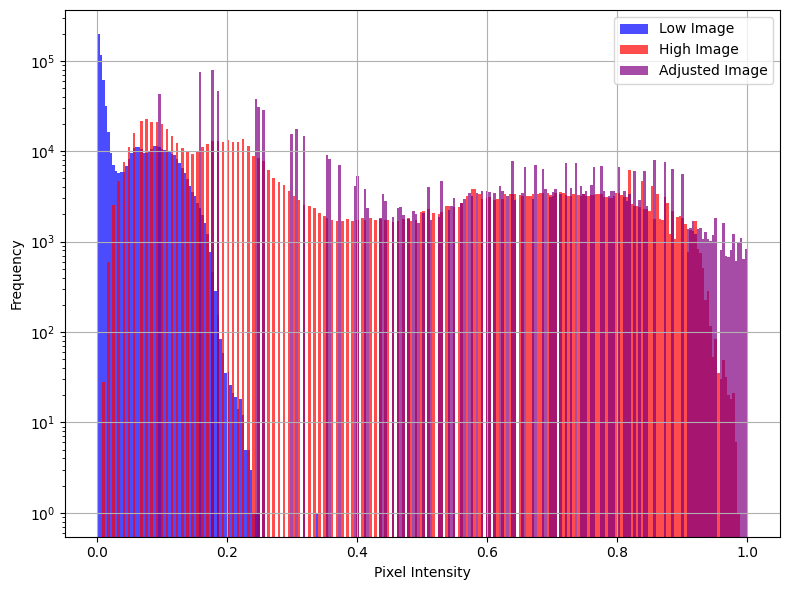

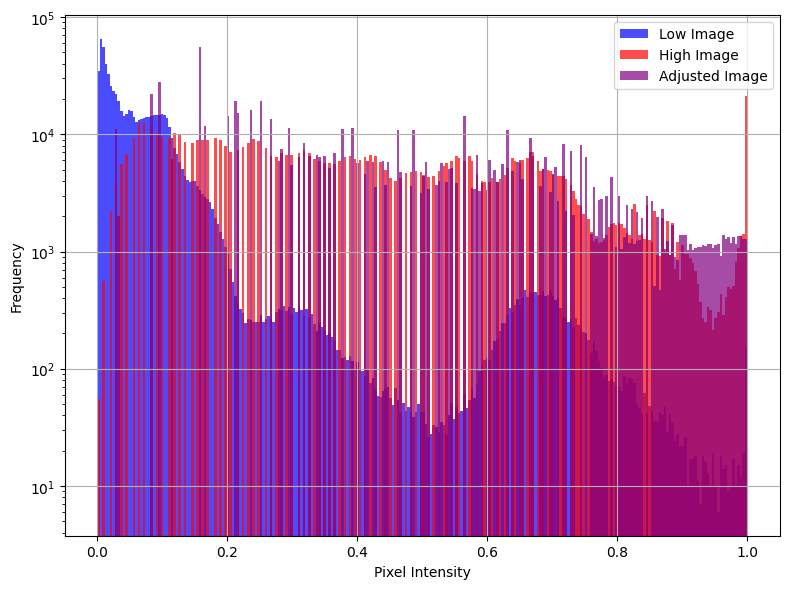

In [26]:
import matplotlib.pyplot as plt

def plot_hist(image, title, color):
    plt.hist(image.flatten(), bins=256, range=(0, 1), color=color, alpha=0.7, label=title)
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.legend()
    plt.yscale('log')

for i in range(1, 3):
    plt.figure(figsize=(8, 6))
    plot_hist(lo[i], 'Low Image', 'blue')
    plot_hist(hi[i], 'High Image', 'red')
    plot_hist(new_inp[i], 'Adjusted Image', 'purple')
    plt.tight_layout()
    plt.show()


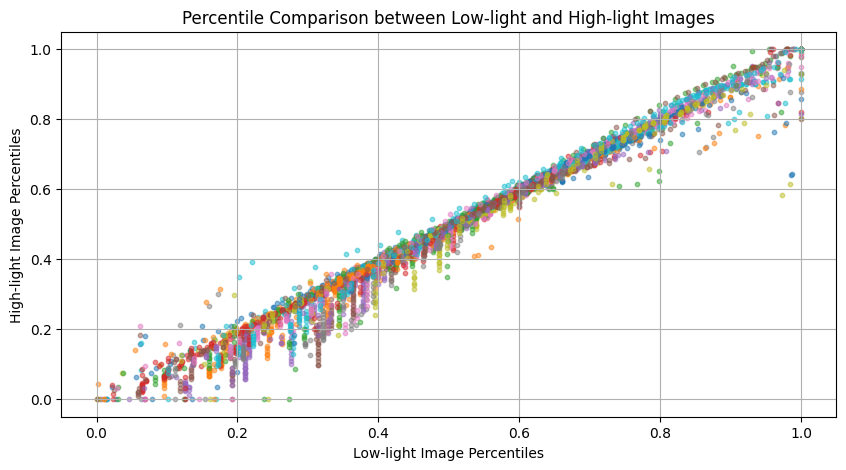

correlations are: [0.9891437680393446, 0.9976727998721502, 0.9989321222909745, 0.999390136697701, 0.9922923274830049, 0.9802806791917203, 0.9989750343661599, 0.9979406721675501, 0.9858275883993219, 0.995551004972296, 0.9678131574995052, 0.9973572519026755, 0.9920430014168982, 0.9956893438291279, 0.994139245568188, 0.9954323188805303, 0.9881737735975634, 0.9838183540008569, 0.9922833004344935, 0.992577527538173, 0.9968923722021125, 0.9799110453409807, 0.9869760828178316, 0.9966849226771036, 0.9956472892711405, 0.9966276578725914, 0.9938216161771343, 0.9813874265438848, 0.9854561665909757, 0.983166147707994, 0.9973874256738273, 0.9827429832592937, 0.999100497711076, 0.9988061315609038, 0.9933003642271211, 0.9939610713691551, 0.9862465706426301, 0.975057104208702, 0.9488634730830627, 0.9937338203213868, 0.9829897344949944, 0.9742654722996508, 0.9034274398415203, 0.9896470374572964, 0.989010228634281, 0.9936932329869355, 0.9983171650723888, 0.9945691762000426, 0.9906501466047334, 0.9977602

In [28]:
new_p , hp = new_inp[:50],hi[:50]
print('correlations are:',corre(new_p, hp, quantiles=np.linspace(0, 100, 100)))

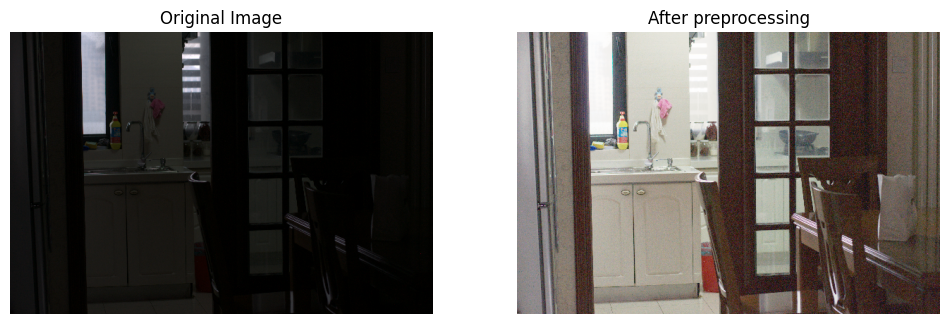

In [29]:
input_image_path = '/kaggle/input/lol-dataset/lol_dataset/our485/low/102.png'

input_image = Image.open(input_image_path).convert('RGB')

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(input_image)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(new_inp[2].permute(1, 2, 0).numpy())
plt.title('After preprocessing')
plt.axis('off')

plt.show()


In [36]:
class PreprocessingLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(PreprocessingLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.weight_norm = nn.utils.weight_norm(self.conv)

    def forward(self, x):
        return F.relu(self.weight_norm(x))

class SpecialConvolutionalModule(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SpecialConvolutionalModule, self).__init__()

        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            #nn.ReLU()
        )

        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            #nn.ReLU()
        )
        
        self.conv1 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.weight_norm1 = nn.utils.weight_norm(self.conv1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.weight_norm2 = nn.utils.weight_norm(self.conv2)
        self.relu = nn.ReLU()

    def forward(self, x):
        branch1_out = self.branch1(x)
        branch2_out = self.branch2(x)
        out = branch1_out + branch2_out
        out = self.relu(self.weight_norm1(out))
        out = self.relu(self.weight_norm2(out))
        return out

class OutputLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutputLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        return self.conv(x)

class LLCNN(nn.Module):
    def __init__(self, in_channels=3, num_modules=17):
        super(LLCNN, self).__init__()
        self.pre_layer = PreprocessingLayer(in_channels, 64)
        self.conv_modules = nn.ModuleList([SpecialConvolutionalModule(64, 64) for _ in range(num_modules)])
        self.output_layer = OutputLayer(64, in_channels)
        self.sgn = nn.Sigmoid()

    def forward(self, x):
        x = self.pre_layer(x)
        residual = x  # Initial residual for the skip connection

        for module in self.conv_modules:
            out = module(x)
            x = out + residual  # Skip connection
            residual = x  # Update residual for next skip connection

        x = self.output_layer(x)
        x = self.sgn(x)
        return x


In [34]:
class MyDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_img = self.inputs[idx]
        target_img = self.targets[idx]
        return input_img, target_img

In [87]:
# hybrid loss function
def hybrid_loss(outputs, targets, alpha=0.5, beta=0.5):
    l1 = F.mse_loss(outputs, targets)
    l2 = F.l1_loss(outputs, targets)
    return l1 + l2

# Initialize the device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LLCNN().to(device)

# Use multiple GPUs if available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

# Initialize optimizer, scheduler, and mixed precision scaler
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
scaler = torch.cuda.amp.GradScaler()

num_epochs = 5
batch_size = 8

# Lists to store loss and PSNR values for each epoch
train_losses = []
train_psnrs = []

validation_split = 0.1  # For example, 10% of the data for validation

# Calculate the number of samples for validation
num_val_samples = int(validation_split * len(new_inp))

# Split the data into training and validation sets
train_new_inp = new_inp[:-num_val_samples]
train_high = hi[:-num_val_samples]
val_new_inp = new_inp[-num_val_samples:]
val_high = hi[-num_val_samples:]

# Define DataLoader for training and validation
train_dataset = MyDataset(train_new_inp, train_high)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = MyDataset(val_new_inp, val_high)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    psnr_sum = 0.0
    num_batches = 0

    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
        for low_imgs, normal_imgs in train_loader:
            low_imgs, normal_imgs = low_imgs.to(device), normal_imgs.to(device)
            optimizer.zero_grad()

            with torch.cuda.amp.autocast():
                outputs = model(low_imgs)
                loss = hybrid_loss(outputs, normal_imgs)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

            with torch.no_grad():
                psnr_value = PSNR(outputs, normal_imgs)
            psnr_sum += psnr_value
            num_batches += 1

            pbar.set_postfix({'Loss': running_loss / (num_batches), 'PSNR': psnr_sum / (num_batches)})
            pbar.update()

    average_loss = running_loss / len(train_loader)
    average_psnr = psnr_sum / len(train_loader)
    print(f"Epoch {epoch+1}, Loss: {average_loss:.4f}, Average PSNR: {average_psnr:.2f} dB")

    # Step the scheduler
    scheduler.step(average_loss)

    # Append loss and PSNR values for plotting
    train_losses.append(average_loss)
    train_psnrs.append(average_psnr)

    # Empty CUDA memory
    torch.cuda.empty_cache()


Using 2 GPUs


Epoch 1/5: 100%|██████████| 55/55 [01:35<00:00,  1.74s/batch, Loss=0.0946, PSNR=tensor(20.2260, device='cuda:0')]


Epoch 1, Loss: 0.0946, Average PSNR: 20.23 dB


Epoch 2/5: 100%|██████████| 55/55 [01:35<00:00,  1.73s/batch, Loss=0.0484, PSNR=tensor(23.8785, device='cuda:0')]


Epoch 2, Loss: 0.0484, Average PSNR: 23.88 dB


Epoch 3/5: 100%|██████████| 55/55 [01:35<00:00,  1.73s/batch, Loss=0.0466, PSNR=tensor(24.2747, device='cuda:0')]


Epoch 3, Loss: 0.0466, Average PSNR: 24.27 dB


Epoch 4/5: 100%|██████████| 55/55 [01:35<00:00,  1.73s/batch, Loss=0.0421, PSNR=tensor(24.8462, device='cuda:0')]


Epoch 4, Loss: 0.0421, Average PSNR: 24.85 dB


Epoch 5/5: 100%|██████████| 55/55 [01:35<00:00,  1.73s/batch, Loss=0.0401, PSNR=tensor(25.1010, device='cuda:0')]


Epoch 5, Loss: 0.0401, Average PSNR: 25.10 dB


In [88]:
torch.save(model.state_dict(), 'model.pth')

In [119]:
joblib_file = "llcn_like.pkl"  
joblib.dump(model, joblib_file)

['llcn_like.pkl']

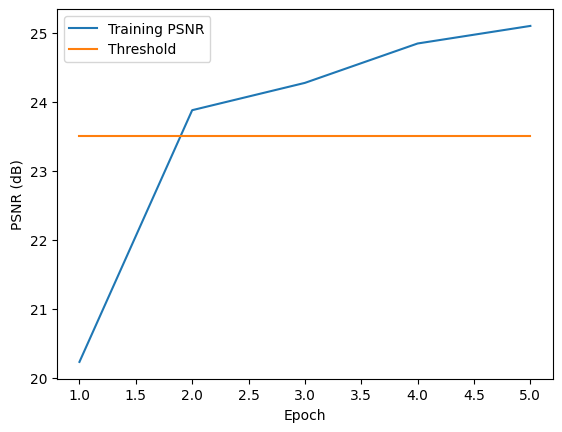

In [90]:
lst = []

for tnsr in train_psnrs:
    lst.append(tnsr.item())
plt.plot(range(1, num_epochs + 1), lst, label='Training PSNR')
plt.plot(range(1, num_epochs + 1), [23.5] * len(lst), label='Threshold')
plt.xlabel('Epoch')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.show()